In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from skimage.segmentation import slic
from skimage.future import graph
from skimage.color import label2rgb
from skimage.measure import regionprops

In [81]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
def load_images(image_A_path, image_B_path):
    image_A = cv2.imread(image_A_path, cv2.IMREAD_GRAYSCALE)
    image_B = cv2.imread(image_B_path, cv2.IMREAD_GRAYSCALE)
    return image_A, image_B

# Environmental Corrections

In [4]:
def correct_environmental_factors(image):
    image_eq = cv2.equalizeHist(image)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image_clahe = clahe.apply(image_eq)
    
    return image_clahe

In [5]:
def display_images(image_A, image_B):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image_A, cmap='gray')
    axes[0].set_title("Image A")
    axes[1].imshow(image_B, cmap='gray')
    axes[1].set_title("Image B")
    plt.show()

#  Feature matching & Aligning

In [6]:
def feature_matching(image_A, image_B):
    orb = cv2.ORB_create()
    kp_A, des_A = orb.detectAndCompute(image_A, None)
    kp_B, des_B = orb.detectAndCompute(image_B, None)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des_A, des_B)
    matches = sorted(matches, key=lambda x: x.distance)
    
    image_matches = cv2.drawMatches(image_A, kp_A, image_B, kp_B, matches[:50], None, flags=2)
    plt.figure(figsize=(12, 6))
    plt.imshow(image_matches, cmap='gray')
    plt.title("Feature Matching Between Image A and Image B")
    plt.show()
    
    return kp_A, kp_B, matches


In [7]:
def align_images_affine(image_A, image_B, kp_A, kp_B, matches):
    src_pts = np.float32([kp_A[m.queryIdx].pt for m in matches[:30]]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_B[m.trainIdx].pt for m in matches[:30]]).reshape(-1, 1, 2)
    
    affine_matrix, _ = cv2.estimateAffine2D(src_pts, dst_pts, method=cv2.RANSAC)
    
    if affine_matrix is not None:
        height, width = image_B.shape
        aligned_A = cv2.warpAffine(image_A, affine_matrix, (width, height))
        return aligned_A
    else:
        print("Affine transformation failed. Reverting to homography.")
        return align_images_homography(image_A, image_B, kp_A, kp_B, matches)

In [8]:
def align_images_homography(image_A, image_B, kp_A, kp_B, matches):
    src_pts = np.float32([kp_A[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_B[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    height, width = image_B.shape
    aligned_A = cv2.warpPerspective(image_A, H, (width, height))
    
    return aligned_A


In [9]:
def overlay_images(image_A, image_B):
    blended = cv2.addWeighted(image_A, 0.5, image_B, 0.5, 0)
    plt.figure(figsize=(8, 8))
    plt.imshow(blended, cmap='gray')
    plt.title("Overlay of Aligned Images")
    plt.show()

In [10]:
# Load images
image_A_path = "A (2).png"
image_B_path = "B (2).png"
image_A, image_B = load_images(image_A_path, image_B_path)


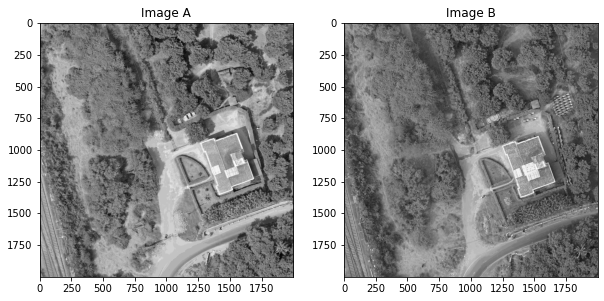

In [11]:

display_images(image_A, image_B)


In [12]:
# Correct environmental factors
image_A = correct_environmental_factors(image_A)
image_B = correct_environmental_factors(image_B)

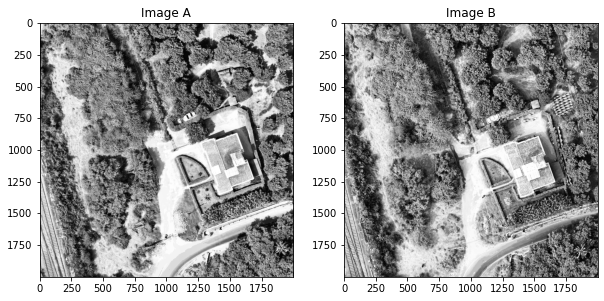

In [13]:

display_images(image_A, image_B)


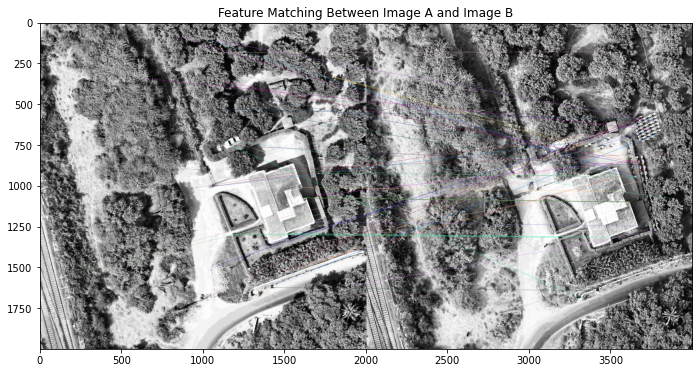

In [14]:
kp_A, kp_B, matches = feature_matching(image_A, image_B)


In [17]:
# Alignment of image A and image B
aligned_A = align_images_affine(image_A, image_B, kp_A, kp_B, matches)
aligned_B = align_images_affine(image_B, image_A, kp_B, kp_A, matches)

display_images(aligned_A, image_B)


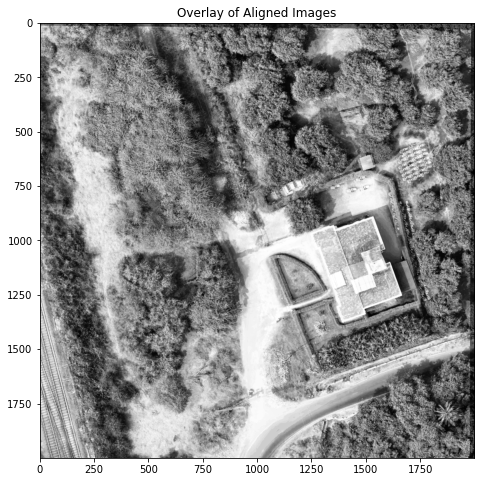

In [19]:
overlay_images(aligned_A, image_B)

In [20]:
aligned_homo = align_images_homography(image_A, image_B, kp_A, kp_B, matches)

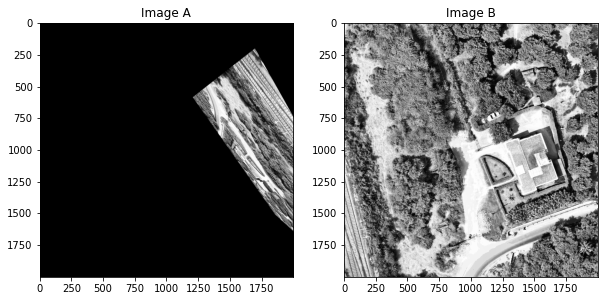

In [21]:
display_images(aligned_homo, image_A)

# Finding changes using threshold and contours

In [22]:
def find_changes(image_A, image_B):
    diff = cv2.absdiff(image_A, image_B)
    _, thresh = cv2.threshold(diff, 90, 255, cv2.THRESH_BINARY)
    
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    change_map = cv2.cvtColor(image_B, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(change_map, contours, -1, (0, 0, 255), 2)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(change_map)
    plt.title("Detected Changes")
    plt.show()

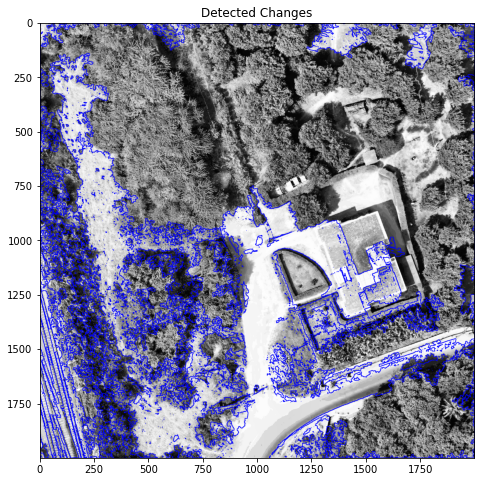

In [23]:
# Detect and display changes
find_changes(cv2.bitwise_or(image_B, aligned_B), image_A)


# TWEAKING AND TUNING parameters to get better output and changes

In [24]:
def find_changesA(image_A, image_B):
    diff = cv2.absdiff(image_A, image_B)
    
    # Apply Gaussian blur to reduce noise
    diff = cv2.GaussianBlur(diff, (5, 5), 0)
    
    # Manually set threshold for better control over detected changes
    _, thresh = cv2.threshold(diff, 130, 255, cv2.THRESH_BINARY)
    
    # Morphological operations to enhance detected regions
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)
    thresh = cv2.dilate(thresh, kernel, iterations=2)
    
    # Find contours of changes
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    change_map = cv2.cvtColor(image_B, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(change_map, contours, -1, (0, 0, 255), 2)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(change_map)
    plt.title("Detected Changes")
    plt.show()
    return thresh if thresh is not None else np.zeros_like(image_A)

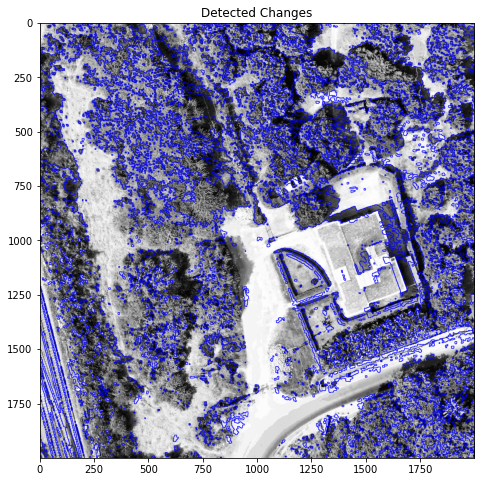

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

In [70]:
# Detect and display changes
find_changesA(cv2.bitwise_or(image_B, aligned_B), image_A)


In [40]:
def find_changesB(image_A, image_B):
    diff = cv2.absdiff(image_A, image_B)
    
    # Apply Gaussian blur to reduce noise while preserving edges
    diff = cv2.GaussianBlur(diff, (5, 5), 0)
    
    # Adaptive thresholding for better contrast in detected changes
    _, thresh = cv2.threshold(diff, 90, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Morphological operations to enhance detected regions
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    
    # Find contours of changes
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    change_map = cv2.cvtColor(image_B, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(change_map, contours, -1, (0, 0, 255), 1)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(change_map)
    plt.title("Enhanced Detected Changes")
    plt.show()

# Load images

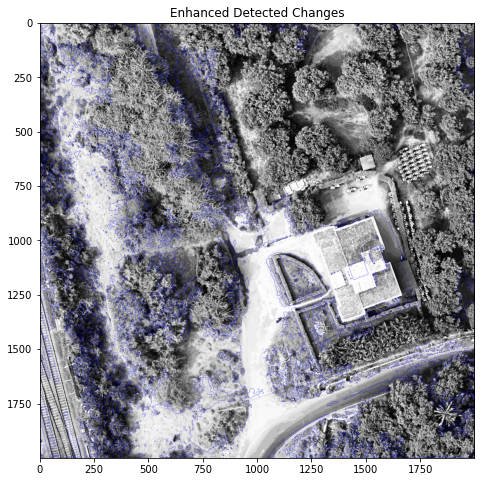

In [27]:
find_changesB(aligned_A, image_B)

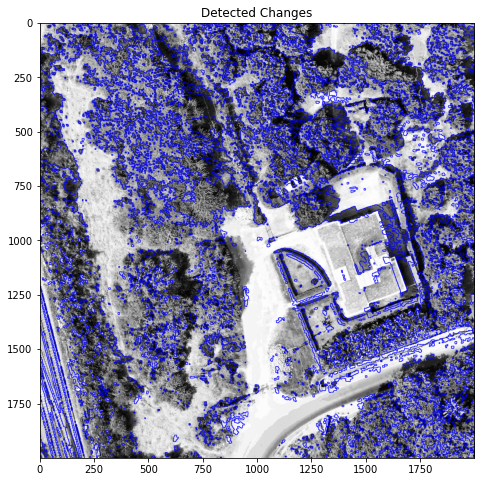

In [71]:
changes = find_changesA(cv2.bitwise_or(image_B, aligned_B), image_A)

# Classifying changes into categories using gaussian mixture mdel and clustering

In [72]:
def segment_and_classify(changes):
    if changes is None or changes.sum() == 0:
        print("No significant changes detected.")
        return
    
    # Reshape image data for clustering
    reshaped = changes[changes > 0].reshape(-1, 1)  # Consider only changed pixels
    
    if len(reshaped) == 0:
        print("No significant changes detected.")
        return
    
    # Apply Gaussian Mixture Model (GMM) clustering
    n_clusters = min(5, len(np.unique(reshaped)))  # Increased number of classes
    print(n_clusters)
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    labels = gmm.fit_predict(reshaped)
    
    # Assign labels back to image shape
    clustered = np.zeros_like(changes)
    clustered[changes > 0] = labels[:len(clustered[changes > 0])] + 1  # Shift labels to avoid zero class
    
    plt.figure(figsize=(8, 8))
    plt.imshow(clustered, cmap='jet')
    plt.title("Segmented and Classified Changes")
    plt.colorbar()
    plt.show()
    
    # Define meaningful categories
    categories = {0: "Vegetation Change", 1: "Urban Expansion", 2: "Water Body Change", 3: "Road Construction", 4: "Deforestation", 5: "Infrastructure Development", 6: "Other Changes"}
    
    # Count occurrences of each category
    unique, counts = np.unique(labels, return_counts=True)
    for i in range(len(unique)):
        print(f"Class {unique[i]}: {categories.get(unique[i], 'Other Changes')} - {counts[i]} pixels")


1


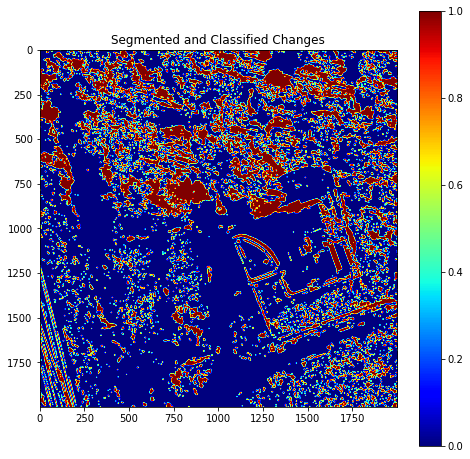

Class 0: Vegetation Change - 1073498 pixels


In [29]:
segment_and_classify(changes)

# Using CNN classifiers to determine changes 

In [45]:
def find_changesC(image_A, image_B):
    diff = cv2.absdiff(image_A, image_B)
    diff = cv2.GaussianBlur(diff, (5, 5), 0)
    _, thresh = cv2.threshold(diff, 130, 255, cv2.THRESH_BINARY)
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)
    thresh = cv2.dilate(thresh, kernel, iterations=2)
    return thresh


In [46]:
# Extract Change Patches
def extract_patches(image, patch_size=32):
    patches = []
    coords = []
    for i in range(0, image.shape[0] - patch_size, patch_size):
        for j in range(0, image.shape[1] - patch_size, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]
            if np.any(patch > 0):  # Consider only patches with changes
                patches.append(patch)
                coords.append((i, j))
    return np.array(patches), coords

In [54]:
# Simple CNN Classifier
def build_cnn_classifier(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(6, activation='softmax')  # 6 Categories
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

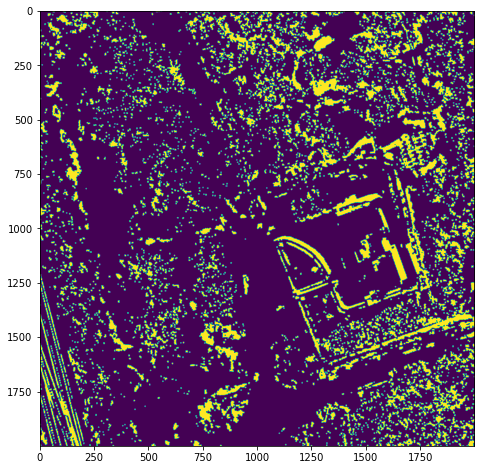

In [75]:
changesC = find_changesC(image_A, image_B)
plt.figure(figsize=(8, 8))
plt.imshow(changesC)

In [ ]:
# Segmenting using Patches

In [49]:

# Classify Segmented Regions
def classify_regions(segmented_image):
    categories = ['Vegetation Change', 'Urban Expansion', 'Water Body Change', 'Road Construction', 'Deforestation', 'Infrastructure Development']
    segmented_labels = np.digitize(segmented_image, bins=np.linspace(0, 1, len(categories))) - 1
    segmented_labels = np.clip(segmented_labels, 0, len(categories) - 1)
    
    plt.imshow(segmented_labels, cmap='tab10')
    plt.title("Classified Changes")
    plt.colorbar()
    plt.show()

In [56]:
# Extract Patches
patches, coords = extract_patches(changes, patch_size=64)  # Adjusted for 64x64 patches
patches = np.expand_dims(patches, axis=-1) / 255.0  # Normalize


In [57]:

# Generate Dummy Labels (Replace with real labels if available)
categories = ['Vegetation Change', 'Urban Expansion', 'Water Body Change', 'Road Construction', 'Deforestation', 'Infrastructure Development']
y_labels = np.random.randint(0, len(categories), size=(len(patches),))
y_labels = to_categorical(y_labels, num_classes=len(categories))

# Train Classifier
X_train, X_test, y_train, y_test = train_test_split(patches, y_labels, test_size=0.2, random_state=42)
classifier = build_cnn_classifier((64, 64, 1))  # Adjusted input size
classifier.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test))


Epoch 1/10
90/90 [==============================] - 3s 27ms/step - loss: 1.8167 - accuracy: 0.1347 - val_loss: 1.7918 - val_accuracy: 0.2099
Epoch 2/10
90/90 [==============================] - 3s 28ms/step - loss: 1.7611 - accuracy: 0.2986 - val_loss: 1.8019 - val_accuracy: 0.2099
Epoch 3/10
90/90 [==============================] - 2s 25ms/step - loss: 1.4177 - accuracy: 0.4764 - val_loss: 2.0819 - val_accuracy: 0.1713
Epoch 4/10
90/90 [==============================] - 2s 26ms/step - loss: 0.5669 - accuracy: 0.8250 - val_loss: 2.9209 - val_accuracy: 0.2376
Epoch 5/10
90/90 [==============================] - 2s 26ms/step - loss: 0.1197 - accuracy: 0.9764 - val_loss: 4.5478 - val_accuracy: 0.1768
Epoch 6/10
90/90 [==============================] - 2s 27ms/step - loss: 0.0320 - accuracy: 0.9972 - val_loss: 4.8642 - val_accuracy: 0.2044
Epoch 7/10
90/90 [==============================] - 2s 26ms/step - loss: 0.0175 - accuracy: 0.9958 - val_loss: 5.0808 - val_accuracy: 0.2155
Epoch 8/10
90

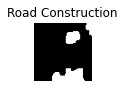

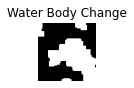

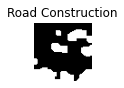

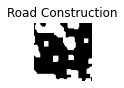

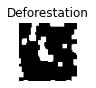

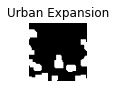

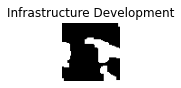

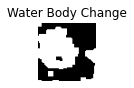

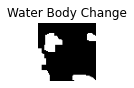

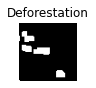

In [67]:
predictions = np.argmax(classifier.predict(patches), axis=1)
segmentation_mask = np.zeros_like(changes)

# Show Classified Patches
for i, (x, y) in enumerate(coords[:10]):  # Show first 10 classified patches
    plt.subplot(2, 5, i+1)
    plt.imshow(patches[i].squeeze(), cmap='gray')
    plt.title(categories[predictions[i]])
    plt.axis('off')
    plt.show()


In [68]:
# Assign Colors to Classes
color_map = {
    0: (0, 255, 0),   # Vegetation Change - Green
    1: (255, 0, 0),   # Urban Expansion - Red
    2: (0, 0, 255),   # Water Body Change - Blue
    3: (255, 255, 0), # Road Construction - Yellow
    4: (139, 69, 19), # Deforestation - Brown
    5: (128, 0, 128)  # Infrastructure Development - Purple
}

In [ ]:

segmented_image = np.zeros((changes.shape[0], changes.shape[1], 3), dtype=np.uint8)
for i, (x, y) in enumerate(coords):
    segmented_image[x:x+64, y:y+64] = color_map[predictions[i]]

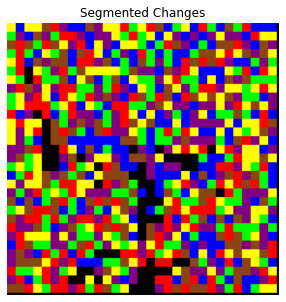

In [69]:
segmented_image = np.zeros((changes.shape[0], changes.shape[1], 3), dtype=np.uint8)
for i, (x, y) in enumerate(coords):
    segmented_image[x:x+64, y:y+64] = color_map[predictions[i]]

# Display Segmented Image
plt.figure(figsize=(10, 5))
plt.imshow(segmented_image)
plt.title("Segmented Changes")
plt.axis("off")
plt.show()


Text(0.5, 1.0, 'Detected Changes')

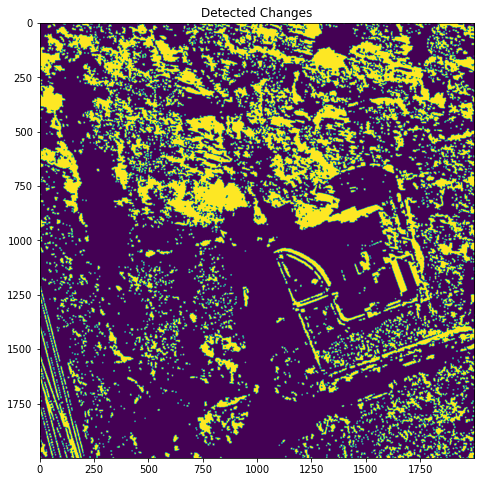

In [44]:
plt.figure(figsize=(8, 8))
plt.imshow(changes)
plt.title("Detected Changes")

In [76]:
def prepare_pixel_data(image_A, image_B, changes):
    features = np.stack([image_A, image_B, changes], axis=-1)
    labels = (changes > 0).astype(np.uint8)
    return features, labels

In [86]:
def build_pixel_classifier(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [87]:
features, labels = prepare_pixel_data(image_A, image_B, changes)
features = features.reshape(-1, 3)
labels = to_categorical(labels.reshape(-1), num_classes=2)

In [88]:

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
classifier = build_pixel_classifier((3,))
classifier.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
100000/100000 [==============================] - 74s 740us/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 2.9802e-12 - val_accuracy: 1.0000
Epoch 2/10
100000/100000 [==============================] - 74s 737us/step - loss: 2.2311e-05 - accuracy: 1.0000 - val_loss: 1.0580e-11 - val_accuracy: 1.0000
Epoch 3/10
100000/100000 [==============================] - 74s 738us/step - loss: 2.6896e-11 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
100000/100000 [==============================] - 76s 761us/step - loss: 2.4032e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
100000/100000 [==============================] - 168s 2ms/step - loss: 1.0527e-05 - accuracy: 1.0000 - val_loss: 5.2154e-12 - val_accuracy: 1.0000
Epoch 6/10
100000/100000 [==============================] - 73s 733us/step - loss: 1.7546e-11 - accuracy: 1.0000 - val_loss: 8.9407e-13 - val_accuracy: 1.0000
Epoch 7/10
100000/100000 [=========================

In [89]:
predictions2 = np.argmax(classifier.predict(features), axis=1).reshape(changes.shape)

In [90]:
# Create Heatmap Representation
heatmap = (predictions2 * 255).astype(np.uint8)
contours, _ = cv2.findContours(heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
segmented_image = cv2.cvtColor(image_B, cv2.COLOR_GRAY2BGR)
cv2.drawContours(segmented_image, contours, -1, (0, 255, 0), 2)


array([[[189, 189, 189],
        [209, 209, 209],
        [233, 233, 233],
        ...,
        [113, 113, 113],
        [ 83,  83,  83],
        [107, 107, 107]],

       [[189, 189, 189],
        [209, 209, 209],
        [233, 233, 233],
        ...,
        [130, 130, 130],
        [122, 122, 122],
        [122, 122, 122]],

       [[189, 189, 189],
        [209, 209, 209],
        [233, 233, 233],
        ...,
        [175, 175, 175],
        [169, 169, 169],
        [169, 169, 169]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [249, 249, 249],
        ...,
        [100, 100, 100],
        [115, 115, 115],
        [115, 115, 115]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [121, 121, 121],
        [121, 121, 121],
        [121, 121, 121]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]]

(-0.5, 1999.5, 1999.5, -0.5)

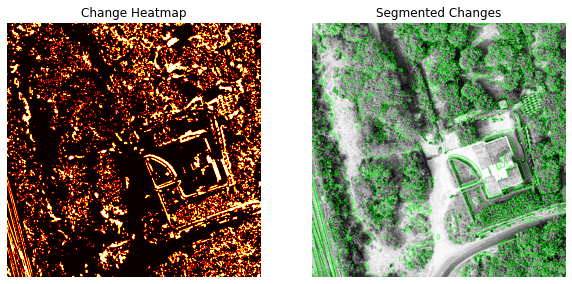

In [91]:
# Display Results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(heatmap, cmap='hot')
plt.title("Change Heatmap")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title("Segmented Changes")
plt.axis("off")


# Classifying using Pixels

In [ ]:
# Display Results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(heatmap, cmap='hot')
plt.title("Change Heatmap")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title("Segmented Changes")
plt.axis("off")


In [95]:
def prepare_pixel_data_2(image_A, image_B, changesA):
    sobelx_A = cv2.Sobel(image_A, cv2.CV_64F, 1, 0, ksize=5)
    sobely_A = cv2.Sobel(image_A, cv2.CV_64F, 0, 1, ksize=5)
    sobelx_B = cv2.Sobel(image_B, cv2.CV_64F, 1, 0, ksize=5)
    sobely_B = cv2.Sobel(image_B, cv2.CV_64F, 0, 1, ksize=5)
    
    features = np.stack([image_A, image_B, changes, sobelx_A, sobely_A, sobelx_B, sobely_B], axis=-1)
    labels = (changes > 0).astype(np.uint8)
    return features, labels


In [101]:
def find_changesD(image_A, image_B):
    diff = cv2.absdiff(image_A, image_B)
    diff = cv2.GaussianBlur(diff, (5, 5), 0)
    
    # Lower threshold to detect minor changes (not just vegetation)
    _, thresh = cv2.threshold(diff, 80, 255, cv2.THRESH_BINARY)
    
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)
    thresh = cv2.dilate(thresh, kernel, iterations=2)
    
    return thresh


In [111]:
changesD = find_changesD(image_A, image_B)

In [97]:
def build_pixel_classifier_2(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [106]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
classifier = build_pixel_classifier((7,))
classifier.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
100000/100000 [==============================] - 85s 843us/step - loss: 0.2019 - accuracy: 0.9969 - val_loss: 3.4124e-11 - val_accuracy: 1.0000
Epoch 2/10
100000/100000 [==============================] - 90s 905us/step - loss: 0.0063 - accuracy: 0.9999 - val_loss: 1.1907e-04 - val_accuracy: 1.0000
Epoch 3/10
100000/100000 [==============================] - 86s 862us/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.0431e-12 - val_accuracy: 1.0000
Epoch 4/10
100000/100000 [==============================] - 85s 851us/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
100000/100000 [==============================] - 88s 883us/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 5.9605e-13 - val_accuracy: 1.0000
Epoch 6/10
100000/100000 [==============================] - 82s 817us/step - loss: 8.5563e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
100000/100000 [==============================] - 79s 79

In [107]:
features, labels = prepare_pixel_data_2(image_A, image_B, changes)
features = features.reshape(-1, features.shape[-1])  # Automatically adjust the last dimension
labels = to_categorical(labels.reshape(-1), num_classes=2)

In [108]:
print(features.shape)  # Debugging: Check the actual shape


(4000000, 7)


In [110]:
# Predict and Create Segmentation Mask
predictions = np.argmax(classifier.predict(features), axis=1).reshape(changes.shape)

# Create Heatmap Representation
heatmap = (predictions * 255).astype(np.uint8)
contours, _ = cv2.findContours(heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
segmented_image = cv2.cvtColor(image_B, cv2.COLOR_GRAY2BGR)
cv2.drawContours(segmented_image, contours, -1, (0, 255, 0), 2)


array([[[189, 189, 189],
        [209, 209, 209],
        [233, 233, 233],
        ...,
        [113, 113, 113],
        [ 83,  83,  83],
        [107, 107, 107]],

       [[189, 189, 189],
        [209, 209, 209],
        [233, 233, 233],
        ...,
        [130, 130, 130],
        [122, 122, 122],
        [122, 122, 122]],

       [[189, 189, 189],
        [209, 209, 209],
        [233, 233, 233],
        ...,
        [175, 175, 175],
        [169, 169, 169],
        [169, 169, 169]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [249, 249, 249],
        ...,
        [100, 100, 100],
        [115, 115, 115],
        [115, 115, 115]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [121, 121, 121],
        [121, 121, 121],
        [121, 121, 121]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]]

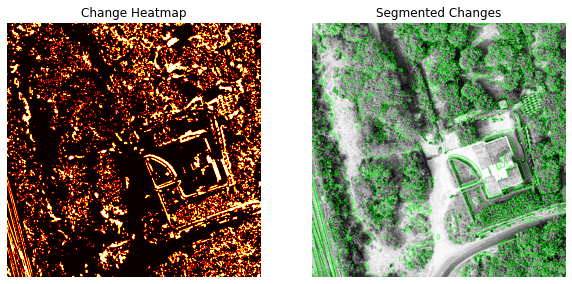

In [112]:

# Display Results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(heatmap, cmap='hot')
plt.title("Change Heatmap")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title("Segmented Changes")
plt.axis("off")

plt.show()
